In [97]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/mnt/home/sliu1/normalizing_flows')
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # disable GPU

rootdir = '/mnt/home/sliu1/ceph/normalizing_flows/qmc_flow'

failed: glmm-poisson, blr, arma, earnings, soil, sir, mesquite, ldaK2, covid19-imperial-v2

succeed: hmm, arK, normal-mixture, eight-schools, garch, logistic, dogs, nes_logit, gp_regr, M0, lotka-volterra, bones, radon, pilots, wells, sesame, onecomp, Mt, pkpd

In [12]:
name = 'onecomp'
# if name == 'corr-normal':
#     ref_moments = {'moment_1': np.zeros(50), 'moment_2': np.ones(50)}
# elif name == 'rosenbrock':
#     ref_moments_1 = np.array([1., 1., 2., 2.])
#     ref_moments_2 = np.array([2., 2., 10.1, 10.1])
# else:
#     filename = f'/mnt/home/sliu1/normalizing_flows/qmc_flow/stan_models/moments_{name}_chain_20_warmup_25000_nsample_50000.pkl'
#     with open(filename, 'rb') as f:
#         moments = pickle.load(f)
#     ref_moments_1 = moments['moment_1'].mean(0)
#     ref_moments_1_var = moments['moment_1'].var(0)
#     ref_moments_2 = moments['moment_2'].mean(0)

date = '2024-09-14'
path = os.path.join(rootdir, date, name)
num_composition = 1
results = {}
losses = {}
ESSs = {}
for num_composition in [1, 3, 5]:
    for max_deg in [3, 5, 7]:
        for m in [6]:
            nsample = 2**m
            for max_iter in [200, 400]:
                for seed in range(10):
                    filename = os.path.join(path, f'tqmc_val_n_{nsample}_comp_{num_composition}_deg_{max_deg}_lbfgs_iter_{max_iter}_lr_1.0_{seed}.pkl')
                    if not os.path.exists(filename):
                        continue
                    with open(filename, 'rb') as f:
                        res = pickle.load(f)
                    ESSs[(num_composition, max_deg, m, max_iter, seed)] = res['ess'][-1]

df_ess = pd.DataFrame(ESSs, index=['ess']).T.reset_index(names=['num_composition', 'max_deg', 'm', 'max_iter', 'seed'])
df_ess['ess'] = df_ess['ess'].astype(float)
df_ess.loc[df_ess['ess'] == np.Inf, 'ess'] = 0


In [13]:
df_ess_max = df_ess.groupby(['num_composition', 'max_deg', 'm', 'max_iter']).max()
df_ess_max = df_ess_max.reset_index()
df_ess_max

,num_composition,max_deg,m,max_iter,seed,ess
0,1,3,6,200,9,51.400425
1,1,3,6,400,9,51.410603
2,1,5,6,200,9,52.775185
3,1,5,6,400,9,52.643665
4,1,7,6,200,9,54.994888
5,1,7,6,400,9,55.772240
6,3,3,6,200,9,53.787968
7,3,3,6,400,9,53.166168
8,3,5,6,200,9,58.016720
9,3,5,6,400,9,55.389870


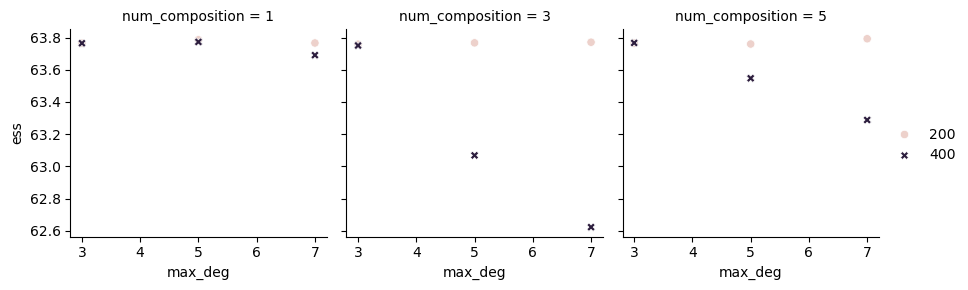

In [17]:
sns.FacetGrid(df_ess_max, col='num_composition').map_dataframe(sns.scatterplot, 'max_deg', 'ess', 'max_iter', style='max_iter').add_legend()

<Axes: xlabel='max_deg', ylabel='ess'>

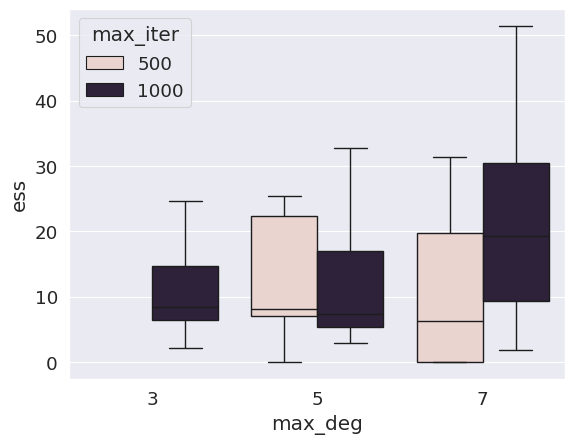

In [209]:
sns.boxplot(data=df_ess[(df_ess['num_composition'] == 1) & (df_ess['m'] == 10)], x='max_deg', y='ess', hue='max_iter')

Text(0.5, 0, 'Number of samples')

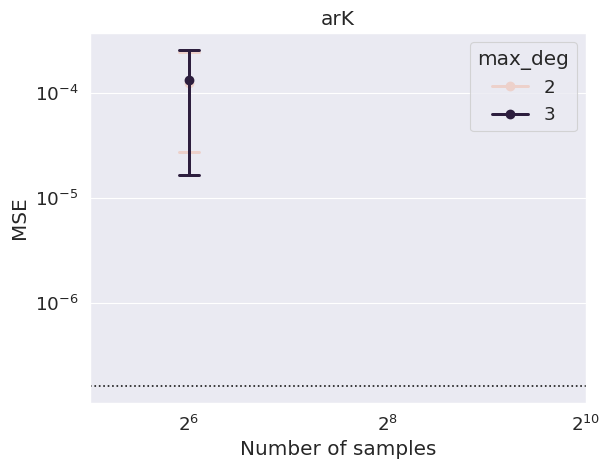

In [124]:
df = pd.DataFrame(results, index=['MSE']).T
df.reset_index(names=['K', 'max_deg', 'm', 'max_iter', 'seed'], inplace=True)

sns.set_theme(context='paper', style='darkgrid', font_scale=1.5)
sns.pointplot(data=df, x='m', hue='max_deg', y='MSE', capsize=.1, errorbar=('ci', 90))
plt.axhline(ref_moments_1_var.mean(), ls=':', color='k')
# sns.boxplot(data=df, x='m', hue='method', y='MSE')
plt.yscale('log', base=10)
plt.title(name)
plt.xticks(range(3), [f'$2^{{{m}}}$' for m in [6, 8, 10]])
plt.xlabel('Number of samples')
# plt.savefig(f'/mnt/home/sliu1/normalizing_flows/qmc_flow/plots/{name}_deg_{max_deg}_iter_{max_iter}_MSE_vs_n.pdf')

In [210]:
def get_best_results(name, nsample, num_composition, max_deg, max_iter):
    path = os.path.join(rootdir, date, name)
    max_ess = -1
    for seed in range(10):
        filename = os.path.join(path, f'tqmc_n_{nsample}_comp_{num_composition}_deg_{max_deg}_lbfgs_iter_{max_iter}_lr_0.001_{seed}.pkl')
        # if not os.path.exists(filename):
        #     continue
        with open(filename, 'rb') as f:
            res = pickle.load(f)
        if res['ess'][-1] > max_ess:
            max_ess = res['ess'][-1]
            best_res = res

    print(f'Best ESS: {max_ess}')
    return best_res
                

In [217]:
name = 'rosenbrock'
nsample = 2**6
num_composition = 5
max_deg = 7
# res2 = get_best_results(name, nsample, num_composition=1, max_deg=3, max_iter=500)
res3 = get_best_results(name, nsample, num_composition=num_composition, max_deg=max_deg, max_iter=1000)

Best ESS: 21.02621841430664


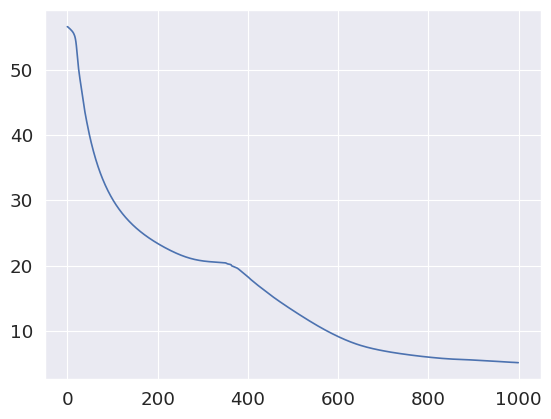

In [219]:
# plt.plot(res2['rkl'])
plt.plot(res3['rkl'])
# plt.plot(res['chisq'] * (-0.5))

## Heatmap

In [95]:
from qmc_flow.utils import make_heatmap
from qmc_flow.targets import StanModel
import jax

ModuleNotFoundError: No module named 'qmc_flow'

In [38]:
name = 'arma'
data_path = f"qmc_flow/stan_models/{name}.json"
stan_path = f"qmc_flow/stan_models/{name}.stan"
target = StanModel(stan_path, data_path)

/mnt/home/sliu1/normalizing_flows/venv_nf/lib/python3.10/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /mnt/home/sliu1/normalizing_flows/qmc_flow/stan_models/arma_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
  warnings.warn(


Text(0, 0.5, 'Dimension 1')

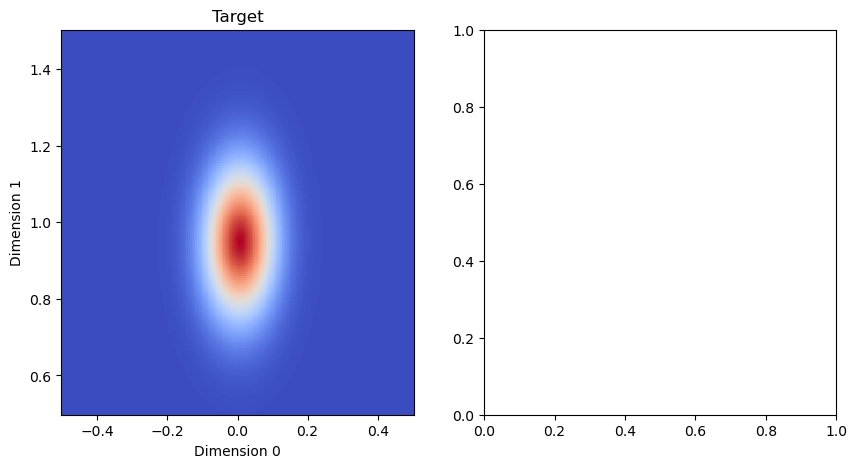

In [39]:
i1 = 0
i2 = 1
grid_size = 200
d = target.d
zz = np.zeros((grid_size**2, d))
xx, yy = np.meshgrid(np.linspace(-.5, .5, grid_size), np.linspace(0.5, 1.5, grid_size))
zz[:, [i1, i2]] = np.concatenate([xx[..., None], yy[..., None]], 2).reshape(-1, 2)

true_log_prob = jax.vmap(target.log_prob)(zz)
offset = np.max(true_log_prob)
true_prob = np.exp(true_log_prob - offset).reshape(xx.shape)
true_prob.max()
true_prob[np.isnan(true_prob)] = 0
# true_prob = true_prob / true_prob.sum() * (1 / (xx[1] - xx[0])**2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(xx, yy, true_prob, cmap='coolwarm', linewidth=0, rasterized=True)
ax[0].set_title('Target')
ax[0].set_xlabel('Dimension ' + str(i1))
ax[0].set_ylabel('Dimension ' + str(i2))

In [44]:
nsample = 2**6
num_composition = 1
max_deg = 3
max_iter = 500
date = '2024-09-11'
rootdir = '/mnt/home/sliu1/ceph/normalizing_flows/qmc_flow'
path = os.path.join(rootdir, date, name)
max_ess = -1
for seed in range(10):
    filename = os.path.join(path, f'tqmc_val_n_{nsample}_comp_{num_composition}_deg_{max_deg}_lbfgs_iter_{max_iter}_lr_1.0_{seed}.pkl')
    if not os.path.exists(filename):
        print(filename)
        continue
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    if res['ess'][-1] > max_ess:
        max_ess = res['ess'][-1]
        params = res['params']
print(f'Best ESS: {max_ess}')

Best ESS: -1


Text(0.5, 1.0, 'nes_logit')

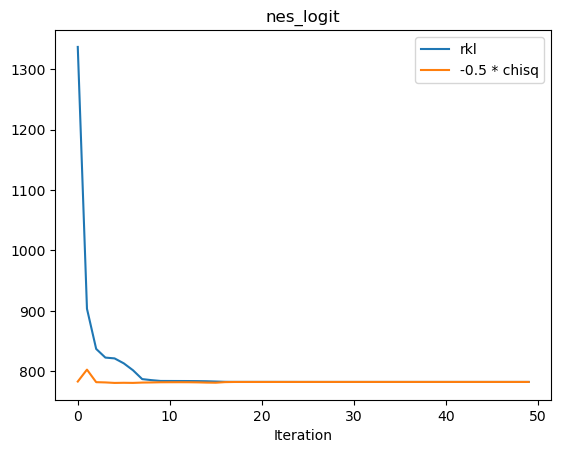

: 

In [145]:
num_composition = 1
max_deg = 3
max_iter = 200
name = 'nes_logit'
seed = 0
path = '/mnt/home/sliu1/ceph/normalizing_flows/qmc_flow/2024-09-14'
filename = os.path.join(path, name, f'tqmc_val_n_64_comp_{num_composition}_deg_{max_deg}_lbfgs_iter_{max_iter}_lr_1.0_{seed}.pkl')
with open(filename, 'rb') as f:
    res = pickle.load(f)
start = 0
end = 50
plt.plot(np.arange(start, end), res['rkl'][start:end], label='rkl')
plt.plot(np.arange(start, end), res['chisq'][start:end] * (-0.5), label='-0.5 * chisq')
plt.legend()
plt.xlabel('Iteration')
plt.title(name)
# plt.savefig(f'qmc_flow/plots/{name}_rkl_chisq.pdf')